In [281]:
from enum import Enum
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from datetime import datetime, timedelta
import re

In [282]:
class MoneyTracker:
    def __init__(self, start_amt: float = 0):
        self.starting_money: float = start_amt
        self.total_money = pd.DataFrame(columns=['Date', 'Total'])
        self.expenses = pd.DataFrame(
            columns=['Date', 'Category', 'Subcategory', 'Description', 'Amount'])
        self.additions = pd.DataFrame(columns=['Date', 'Category', 'Amount'])

    def load_expenses_csv(self, file_path: str):
        # Read CSV file
        expenses_df = pd.read_csv(file_path)

        # Convert 'Date' column to datetime and 'Amount' column to float
        expenses_df['Date'] = pd.to_datetime(expenses_df['Date']).dt.date

        # Evaluate expressions in 'Amount' column
        def evaluate_expression(expression):
            try:
                return eval(expression)
            except:
                raise ValueError('Invalid expression in Amount column. Please use only numbers and the operators +, -, *, /.')
                return None

        expenses_df['Amount'] = expenses_df['Amount'].apply(lambda x: evaluate_expression(x) if isinstance(
            x, str) and re.match(r'^\s*\d+(\.\d+)?\s*(\+|\-|\*|\/)\s*\d+(\.\d+)?\s*$', x) else x)
        expenses_df['Amount'] = expenses_df['Amount'].astype(float)

        # Assign the DataFrame to self.expenses
        self.expenses = expenses_df

    def load_additions_csv(self, file_path: str):
        # Read CSV file
        additions_df = pd.read_csv(file_path)

        # Convert 'Date' column to datetime and 'Amount' column to float
        additions_df['Date'] = pd.to_datetime(additions_df['Date']).dt.date
        
        # Evaluate expressions in 'Amount' column
        def evaluate_expression(expression):
            try:
                return eval(expression)
            except:
                raise ValueError('Invalid expression in Amount column. Please use only numbers and the operators +, -, *, /.')
                return None

        additions_df['Amount'] = additions_df['Amount'].apply(lambda x: evaluate_expression(x) if isinstance(
            x, str) and re.match(r'^\s*\d+(\.\d+)?\s*(\+|\-|\*|\/)\s*\d+(\.\d+)?\s*$', x) else x)
        additions_df['Amount'] = additions_df['Amount'].astype(float)

        # Assign the DataFrame to self.additions
        self.additions = additions_df

    def add_expense(self, date: datetime, category: str, subcategory: str, amount: float, description: str = None):
        self.expenses = self.expenses.append({'Date': datetime.strptime(date, '%Y-%m-%d').date(),
                                              'Category': category,
                                              'Subcategory': subcategory,
                                              'Description': description,
                                              'Amount': amount}, ignore_index=True)

    def add_income(self, date: datetime, category: str, amount: float):
        self.additions = self.additions.append(pd.DataFrame({'Date': [datetime.strptime(date, '%Y-%m-%d').date()],
                                                             'Category': [category],
                                                             'Amount': [amount]}), ignore_index=True)

    def process_total_money(self):
        # Find the earliest transaction date
        earliest_date = min(
            pd.concat([self.expenses['Date'], self.additions['Date']]))
        latest_date = max(
            pd.concat([self.expenses['Date'], self.additions['Date']]))

        # Initialize total money for the earliest date
        current_date = earliest_date
        total_money = self.starting_money

        # Create a list to store daily total money
        daily_totals = []

        # Iterate from the earliest date to the current date
        while current_date <= latest_date:
            # Calculate total money for the current date
            current_expenses = self.expenses[self.expenses['Date']
                                             == current_date]
            current_additions = self.additions[self.additions['Date']
                                               == current_date]
            total_money += current_additions['Amount'].sum() - \
                current_expenses['Amount'].sum()

            # Append the total money for the current date to the list
            daily_totals.append({'Date': current_date, 'Total': total_money})

            # Move to the next day
            current_date += timedelta(days=1)

        # Create DataFrame from the list of daily totals
        self.total_money = pd.DataFrame(daily_totals)

    def plot_total_money_over_time(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.total_money['Date'],
                 self.total_money['Total'], marker='o')
        plt.title('Total Money Over Time')
        plt.xlabel('Date')
        plt.ylabel('Total Money')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

    def plot_spending_pie_chart(self, days_ago: int = 30):
        # Get expenses from the last [days] days
        x_days_ago = datetime.now().date() - timedelta(days=days_ago)
        last_x_days = self.expenses[(self.expenses['Date'] >= x_days_ago) & (
            self.expenses['Date'] <= datetime.now().date())]

        # Group expenses by subcategory and sum up the amounts
        expenses_by_category = last_x_days.groupby('Category')['Amount'].sum()

        # Plot the pie chart
        plt.figure(figsize=(8, 8))
        plt.pie(expenses_by_category, labels=expenses_by_category.index,
                autopct='%1.1f%%', startangle=140)
        plt.title(f'Expenses Distribution (Last {days_ago} Days)')
        # Equal aspect ratio ensures that pie is drawn as a circle
        plt.axis('equal')
        plt.legend()
        plt.show()

        # Group expenses by category and subcategory and sum up the amounts
        grouped_expenses = last_x_days.groupby(
            ['Category', 'Subcategory'])['Amount'].sum()

        # Plot a pie chart for each category
        for category in grouped_expenses.index.levels[0]:
            category_expenses = grouped_expenses.loc[category]
            plt.figure(figsize=(4, 4))
            plt.pie(category_expenses, labels=category_expenses.index,
                    autopct='%1.1f%%', startangle=140)
            plt.title(f'{category} Expenses Distribution (Last {days_ago} Days)')
            # Equal aspect ratio ensures that pie is drawn as a circle
            plt.axis('equal')
            plt.legend()
            plt.show()

    def plot_income_pie_chart(self, days_ago: int = 30):
        # Get additions from the last [days] days
        x_days_ago = datetime.now().date() - timedelta(days=days_ago)
        last_x_days = self.additions[(self.additions['Date'] >= x_days_ago) & (
            self.additions['Date'] <= datetime.now().date())]

        # Group additions by subcategory and sum up the amounts
        additions_by_category = last_x_days.groupby('Category')[
            'Amount'].sum()

        # Plot the pie chart
        plt.figure(figsize=(5, 5))
        plt.pie(additions_by_category, labels=additions_by_category.index,
                autopct='%1.1f%%', startangle=140)
        plt.title(f'Additions Distribution (Last {days_ago} Days)')
        # Equal aspect ratio ensures that pie is drawn as a circle
        plt.axis('equal')
        plt.legend()
        plt.show()

    def plot_balance_difference(self, days_ago: int = 30):
        # Calculate the date x days ago
        thirty_days_ago = datetime.now().date() - timedelta(days=days_ago)

        # Filter expenses and additions where the date is between x days ago and today
        last_x_days_expenses = self.expenses[(self.expenses['Date'] >= thirty_days_ago) & (
            self.expenses['Date'] <= datetime.now().date())]
        last_x_days_additions = self.additions[(self.additions['Date'] >= thirty_days_ago) & (
            self.additions['Date'] <= datetime.now().date())]

        # Calculate the total expenses sum and total additions sum in the last x days
        total_expenses_sum = last_x_days_expenses['Amount'].sum()
        total_additions_sum = last_x_days_additions['Amount'].sum()

        # Plot the grouped bar chart
        plt.figure(figsize=(8, 6))
        plt.bar(['Expenses', 'Additions'], [
                total_expenses_sum, total_additions_sum])
        plt.title(f'Total Expenses and Additions in Last {days_ago} Days')
        plt.xlabel('Category')
        plt.ylabel('Amount')
        plt.show()

In [283]:
tracker = MoneyTracker(0)

In [284]:
# Add some expenses and additions
tracker.load_additions_csv('additions.csv')
tracker.load_expenses_csv('expenses.csv')

In [285]:
# Process total money
tracker.process_total_money()
tracker.total_money

,Date,Total
0,2024-02-01,-1082.11
1,2024-02-02,272.67
2,2024-02-03,272.67
3,2024-02-04,224.82
4,2024-02-05,216.14
5,2024-02-06,203.58
6,2024-02-07,171.34
7,2024-02-08,171.34
8,2024-02-09,112.35
9,2024-02-10,-104.16


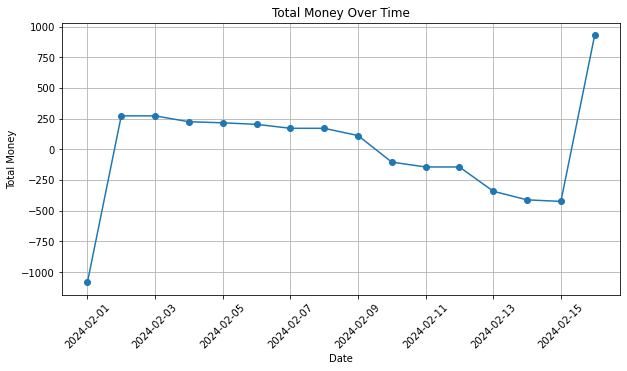

In [286]:
# Plotting
tracker.plot_total_money_over_time()

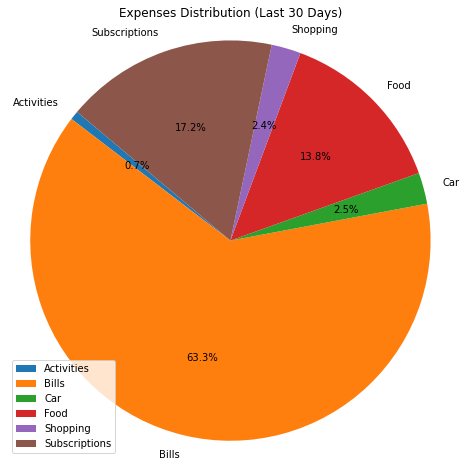

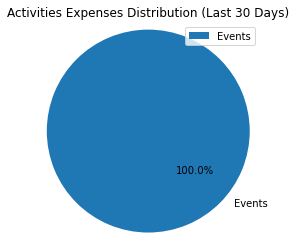

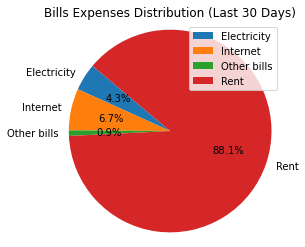

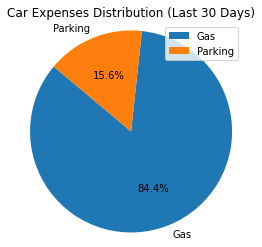

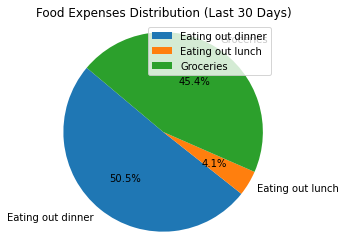

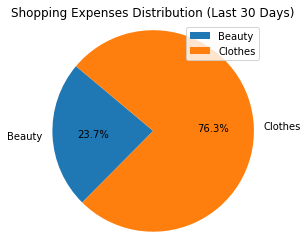

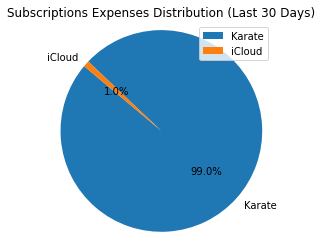

In [287]:
tracker.plot_spending_pie_chart()

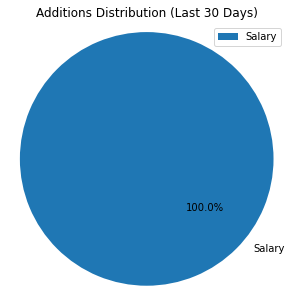

In [288]:
tracker.plot_income_pie_chart()

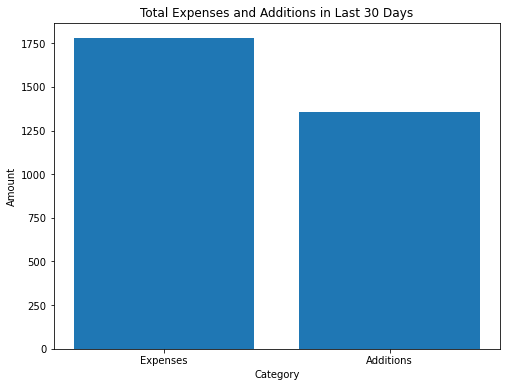

In [289]:
tracker.plot_balance_difference()